### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

POPULATION_SIZE = city_paras["Leeds"]['population']

# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=0.8)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2021-05-15 23:06:21.765 INFO     Building a set of 317255 households from which to build a population
2021-05-15 23:07:35.242 INFO     310483 households of mean size 2.55
2021-05-15 23:07:39.127 INFO     140981 buildings of mean size 5.63
2021-05-15 23:08:08.856 INFO     2022 classrooms of mean size 29.48
2021-05-15 23:08:09.201 INFO     130 care_homes of mean size 106.08
2021-05-15 23:08:10.007 INFO     93249 workplaces of mean size 5.62
2021-05-15 23:08:12.777 INFO     66.0% of workplaces closed by lockdown, leaving 33418 open, of average Income Decile 4.88 (and st dev 3.13).
2021-05-15 23:08:12.955 INFO     66.0% of classrooms closed by lockdown, leaving 718 open, of average Income Decile 4.37 (and st dev 3.11).
2021-05-15 23:08:12.983 INFO    

### Create the 2 variants

In [4]:
from codit.disease import Covid

kent_variant = Covid(name="B.1.1.7")
indian_variant = Covid(name="B.1.617.2")

### Burn in the simulation

In [5]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 18
WINTER_PREVALENCE = 1/50
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-15 23:08:43.408 INFO     Day 1, prop infected is 0.02, prop infectious is 0.0141
2021-05-15 23:10:09.241 INFO     Day 18, prop infected is 0.08, prop infectious is 0.0223


### Run the simulation for January and February

2021-05-15 23:10:43.719 INFO     Day 1, prop infected is 0.09, prop infectious is 0.0219
2021-05-15 23:14:47.365 INFO     Day 51, prop infected is 0.17, prop infectious is 0.0059
2021-05-15 23:15:21.283 INFO     Day 60, prop infected is 0.17, prop infectious is 0.0041
2021-05-15 23:15:22.965 INFO      Realized R0 of early infections is 0.95
2021-05-15 23:15:22.966 INFO      17.2 percent of the population was infected during the epidemic


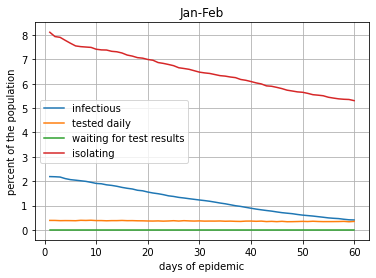

In [6]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.2 others randomly per day
  3. Vaccinate the over 60s

In [7]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.2)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for p in pop.people:
    if p.age > 60:
        p.vaccinate_with("AstraZeneca")

2021-05-15 23:15:26.085 INFO     66.0% of workplaces closed by lockdown, leaving 33326 open, of average Income Decile 4.87 (and st dev 3.14).
2021-05-15 23:15:26.338 INFO     0.0% of classrooms closed by lockdown, leaving 1636 open, of average Income Decile 4.73 (and st dev 3.09).
2021-05-15 23:15:26.368 INFO     Adding 345575 permanent contact groups
2021-05-15 23:15:26.590 INFO     Adding 79314 ephemeral contact pairs
2021-05-15 23:15:27.488 INFO     Adding 239861 contacts each within one of the 140981 buildings (contact density of 0.75)


2021-05-15 23:16:07.870 INFO     Day 1, prop infected is 0.17, prop infectious is 0.0040
2021-05-15 23:17:52.296 INFO     Day 30, prop infected is 0.18, prop infectious is 0.0027
2021-05-15 23:17:53.858 INFO      Realized R0 of early infections is 0.95
2021-05-15 23:17:53.858 INFO      18.4 percent of the population was infected during the epidemic


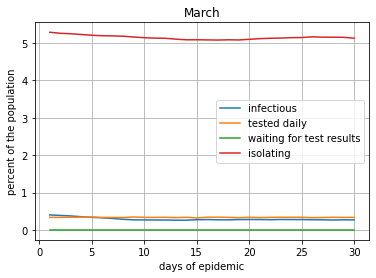

In [8]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [10]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.seed_infections(10, indian_variant)

for p in pop.people:
    if p.age > 50:
        p.vaccinate_with("AstraZeneca")

2021-05-15 23:18:44.882 INFO     50.0% of workplaces closed by lockdown, leaving 49173 open, of average Income Decile 4.87 (and st dev 3.13).
2021-05-15 23:18:45.103 INFO     0.0% of classrooms closed by lockdown, leaving 1661 open, of average Income Decile 4.75 (and st dev 3.08).
2021-05-15 23:18:45.131 INFO     Adding 361447 permanent contact groups
2021-05-15 23:18:45.410 INFO     Adding 118971 ephemeral contact pairs
2021-05-15 23:18:46.263 INFO     Adding 239429 contacts each within one of the 140981 buildings (contact density of 0.75)


2021-05-15 23:19:28.819 INFO     Day 1, prop infected is 0.18, prop infectious is 0.0027
2021-05-15 23:21:15.536 INFO     Day 30, prop infected is 0.20, prop infectious is 0.0026
2021-05-15 23:21:17.153 INFO      Realized R0 of early infections is 0.95
2021-05-15 23:21:17.154 INFO      19.5 percent of the population was infected during the epidemic


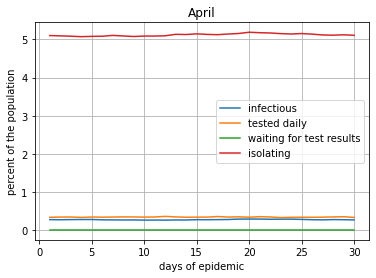

In [11]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [12]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

2021-05-15 23:21:20.315 INFO     33.0% of workplaces closed by lockdown, leaving 62314 open, of average Income Decile 4.91 (and st dev 3.13).
2021-05-15 23:21:20.531 INFO     0.0% of classrooms closed by lockdown, leaving 1641 open, of average Income Decile 4.74 (and st dev 3.07).
2021-05-15 23:21:20.561 INFO     Adding 374568 permanent contact groups
2021-05-15 23:21:21.005 INFO     Adding 198285 ephemeral contact pairs
2021-05-15 23:21:21.865 INFO     Adding 239586 contacts each within one of the 140981 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16

In [13]:
for p in pop.people:
    if p.age > 16:
        p.vaccinate_with('AstraZeneca')

2021-05-15 23:22:07.699 INFO     Day 1, prop infected is 0.20, prop infectious is 0.0026
2021-05-15 23:23:51.926 INFO     Day 30, prop infected is 0.20, prop infectious is 0.0005
2021-05-15 23:23:53.577 INFO      Realized R0 of early infections is 0.95
2021-05-15 23:23:53.577 INFO      19.9 percent of the population was infected during the epidemic


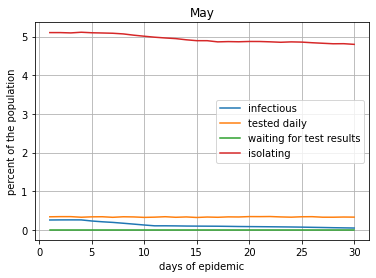

In [14]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")